<a href="https://colab.research.google.com/github/dc-neo/movie_plot/blob/main/model_selection_genre_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Selection
```
# This is formatted as code
```



In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 41.2 MB/s eta 0:00:00


In [2]:
!pip install -q -U "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 31.4 MB/s eta 0:00:00


In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
os.getcwd()
os.chdir('/content/gdrive/MyDrive/Colab Notebooks')
os.getcwd()

'/content/gdrive/MyDrive/Colab Notebooks'

Read the cleaned text plot, balanced dataframe from the database.

In [6]:
import sqlite3
import pandas as pd
sql = """
SELECT p.* FROM plot_nlp p
"""
with sqlite3.connect('movie_plots.db') as con:
    df = pd.read_sql_query(sql, con)

In [7]:
df.head()

,index,release_year,title,originethnicity,director,cast,genre,wiki_page,plot,plot_clean,plot_lemma,plot_nouns,plot_adjectives,plot_verbs,plot_nav,no_tokens
0,0,1997,Arasiyal,Tamil,R. K. Selvamani,"Mammootty, Shilpa Shirodkar, Roja\r\n",unknown,https://en.wikipedia.org/wiki/Arasiyal,Chandrasekhar (Mammootty) is an honest collect...,Chandrasekhar (Mammootty) is an honest collect...,Chandrasekhar ( Mammootty ) be an honest colle...,Chandrasekhar Mammootty collector Vikram Anand...,honest international hopeless corrupt honest a...,arrest transfer eradicate have meet suspect ta...,Chandrasekhar Mammootty collector Vikram Anand...,327
1,1,2002,Yeh Mohabbat Hai,Bollywood,Unknown,"Rahul Bhatt, Johnny Lever",unknown,https://en.wikipedia.org/wiki/Yeh_Mohabbat_Hai,Yeh Mohabbat Hai revolves around Chand & Shahe...,Yeh Mohabbat Hai revolves around Chand & Shahe...,Yeh Mohabbat Hai revolve around Chand & Shahee...,Yeh Mohabbat Hai Chand Shaheen lover childhood...,opposite sufficient innocent,revolve gather play trap claim have convict be...,Yeh Mohabbat Hai Chand Shaheen lover childhood...,113
2,2,2010,Aridhu Aridhu,Tamil,K. R. Mathivannan,"Harish Kalyan, Uttara Raj, Princess Jasmine",unknown,https://en.wikipedia.org/wiki/Aridhu_Aridhu,"The film has been shot in Chennai, Australia a...","The film has been shot in Chennai, Australia a...","the film have be shoot in Chennai , Australia ...",film Chennai Australia New Zealand film terror...,,shoot deal happen,film Chennai Australia New Zealand film terror...,27
3,3,2011,Varnam,Tamil,S. M. Raju,"Giri, Ashwatha, Monica, Sampath Raj",unknown,https://en.wikipedia.org/wiki/Varnam_(2011_film),Mani (Giri) becomes a spoiled brat after his f...,Mani (Giri) becomes a spoiled brat after his f...,Mani ( Giri ) become a spoiled brat after his ...,Mani Giri brat father death caste clash Mani m...,spoiled rich own dear,become send enjoy wait revenge fall influence ...,Mani Giri brat father death caste clash Mani m...,169
4,4,2012,Les Misérables,British,Director: Tom Hooper,"Director: Tom Hooper\r\nCast: Hugh Jackman, Ru...",unknown,https://en.wikipedia.org/wiki/Les_Mis%C3%A9rab...,"In 1815, French prisoner Jean Valjean is relea...","In 1815, French prisoner Jean Valjean is relea...","in 1815 , french prisoner Jean Valjean be rele...",prisoner Jean Valjean parole Bagne Toulon year...,french multiple kindly worthwhile valjean new ...,release serve steal try escape parole prevent ...,prisoner Jean Valjean parole Bagne Toulon year...,739


In [8]:
df.describe()

,index,release_year,no_tokens
count,4960.000000,4960.000000,4960.000000
mean,2479.500000,1973.991532,438.094960
std,1431.972998,27.960771,372.796916
min,0.000000,1902.000000,6.000000
25%,1239.750000,1950.000000,140.000000
50%,2479.500000,1973.000000,336.000000
75%,3719.250000,2001.000000,697.000000
max,4959.000000,2017.000000,5893.000000


In [9]:
df = df.rename(columns={"plot": "plot_describe"})

In [10]:
df['genre'].unique()

array(['unknown', 'drama', 'comedy', 'horror', 'action', 'thriller',
       'romance', 'western', 'crime', 'adventure', 'musical',
       'crime drama', 'romantic comedy', 'science fiction', 'film noir',
       'mystery'], dtype=object)

In [11]:
value_map = {'crime drama': 'crime|drama', 'romantic comedy': 'romantic|comedy', 'science fiction': 'science|fiction', 'film noir' : 'film|noir'}
df['genre_corrected'] = df['genre'].replace(value_map)

In [12]:
df['count']=1
df[['genre','count']].groupby(['genre'], as_index=False).count().shape[0]

16

In [13]:
import numpy as np
df['genre_split']=df['genre_corrected'].str.split('|')
df['genre_split']= df['genre_split'].apply(np.sort).apply(np.unique)

In [14]:
total_count = df.shape[0]
genre_counts = df['genre_split'].value_counts()
total_count

4960

In [15]:
genre_counts.values/total_count

array([0.0625    , 0.0625    , 0.0625    , ..., 0.00020161, 0.00020161,
       0.00020161])

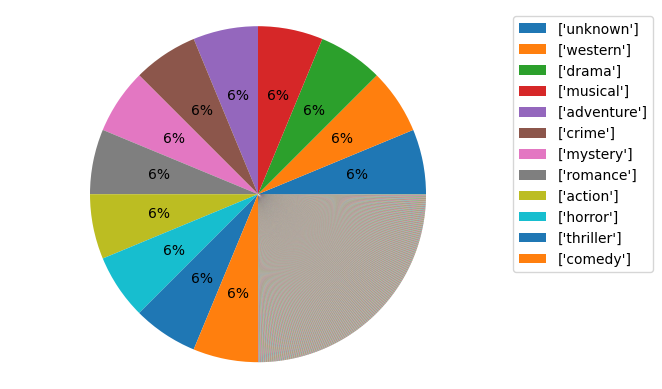

In [16]:
import matplotlib.pyplot as plt
import numpy as np

sizes = pd.DataFrame(genre_counts.values/total_count, index = genre_counts.index)

fig1, ax = plt.subplots()
def autopct_more_than_1(pct):
    return ('%1.f%%' % pct) if pct > 0.5 else ''

p,t,a = ax.pie(sizes.values.reshape(1,-1)[0], autopct=autopct_more_than_1)
ax.axis('equal')

# normalize dataframe (not actually needed here, but for general case)
normsizes = sizes/sizes.sum()*100
# create handles and labels for legend, take only those where value is > 1
h,l = zip(*[(h,lab) for h,lab,i in zip(p,sizes.index.values,normsizes.values) if i > 1])

ax.legend(h, l,loc="best", bbox_to_anchor=(1,1))
plt.show()

In [17]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [18]:
df['plot_clean'] = df['plot_describe'].apply(clean_text)

In [19]:
df.head()

,index,release_year,title,originethnicity,director,cast,genre,wiki_page,plot_describe,plot_clean,plot_lemma,plot_nouns,plot_adjectives,plot_verbs,plot_nav,no_tokens,genre_corrected,count,genre_split
0,0,1997,Arasiyal,Tamil,R. K. Selvamani,"Mammootty, Shilpa Shirodkar, Roja\r\n",unknown,https://en.wikipedia.org/wiki/Arasiyal,Chandrasekhar (Mammootty) is an honest collect...,chandrasekhar mammootty is an honest collector...,Chandrasekhar ( Mammootty ) be an honest colle...,Chandrasekhar Mammootty collector Vikram Anand...,honest international hopeless corrupt honest a...,arrest transfer eradicate have meet suspect ta...,Chandrasekhar Mammootty collector Vikram Anand...,327,unknown,1,[unknown]
1,1,2002,Yeh Mohabbat Hai,Bollywood,Unknown,"Rahul Bhatt, Johnny Lever",unknown,https://en.wikipedia.org/wiki/Yeh_Mohabbat_Hai,Yeh Mohabbat Hai revolves around Chand & Shahe...,yeh mohabbat hai revolves around chand shaheen...,Yeh Mohabbat Hai revolve around Chand & Shahee...,Yeh Mohabbat Hai Chand Shaheen lover childhood...,opposite sufficient innocent,revolve gather play trap claim have convict be...,Yeh Mohabbat Hai Chand Shaheen lover childhood...,113,unknown,1,[unknown]
2,2,2010,Aridhu Aridhu,Tamil,K. R. Mathivannan,"Harish Kalyan, Uttara Raj, Princess Jasmine",unknown,https://en.wikipedia.org/wiki/Aridhu_Aridhu,"The film has been shot in Chennai, Australia a...",the film has been shot in chennai australia an...,"the film have be shoot in Chennai , Australia ...",film Chennai Australia New Zealand film terror...,,shoot deal happen,film Chennai Australia New Zealand film terror...,27,unknown,1,[unknown]
3,3,2011,Varnam,Tamil,S. M. Raju,"Giri, Ashwatha, Monica, Sampath Raj",unknown,https://en.wikipedia.org/wiki/Varnam_(2011_film),Mani (Giri) becomes a spoiled brat after his f...,mani giri becomes a spoiled brat after his fat...,Mani ( Giri ) become a spoiled brat after his ...,Mani Giri brat father death caste clash Mani m...,spoiled rich own dear,become send enjoy wait revenge fall influence ...,Mani Giri brat father death caste clash Mani m...,169,unknown,1,[unknown]
4,4,2012,Les Misérables,British,Director: Tom Hooper,"Director: Tom Hooper\r\nCast: Hugh Jackman, Ru...",unknown,https://en.wikipedia.org/wiki/Les_Mis%C3%A9rab...,"In 1815, French prisoner Jean Valjean is relea...",in 1815 french prisoner jean valjean is releas...,"in 1815 , french prisoner Jean Valjean be rele...",prisoner Jean Valjean parole Bagne Toulon year...,french multiple kindly worthwhile valjean new ...,release serve steal try escape parole prevent ...,prisoner Jean Valjean parole Bagne Toulon year...,739,unknown,1,[unknown]


In [20]:
import pandas as pd

# Perform one-hot encoding using get_dummies
encoded_columns = pd.get_dummies(df['genre'])

# Concatenate the one-hot encoded columns with the original DataFrame
df = pd.concat([df, encoded_columns], axis=1)

# Drop the original categorical column if needed
#df_encoded = df_encoded.drop('Category', axis=1)

# Display the resulting DataFrame
df.head()

,index,release_year,title,originethnicity,director,cast,genre,wiki_page,plot_describe,plot_clean,...,film noir,horror,musical,mystery,romance,romantic comedy,science fiction,thriller,unknown,western
0,0,1997,Arasiyal,Tamil,R. K. Selvamani,"Mammootty, Shilpa Shirodkar, Roja\r\n",unknown,https://en.wikipedia.org/wiki/Arasiyal,Chandrasekhar (Mammootty) is an honest collect...,chandrasekhar mammootty is an honest collector...,...,0,0,0,0,0,0,0,0,1,0
1,1,2002,Yeh Mohabbat Hai,Bollywood,Unknown,"Rahul Bhatt, Johnny Lever",unknown,https://en.wikipedia.org/wiki/Yeh_Mohabbat_Hai,Yeh Mohabbat Hai revolves around Chand & Shahe...,yeh mohabbat hai revolves around chand shaheen...,...,0,0,0,0,0,0,0,0,1,0
2,2,2010,Aridhu Aridhu,Tamil,K. R. Mathivannan,"Harish Kalyan, Uttara Raj, Princess Jasmine",unknown,https://en.wikipedia.org/wiki/Aridhu_Aridhu,"The film has been shot in Chennai, Australia a...",the film has been shot in chennai australia an...,...,0,0,0,0,0,0,0,0,1,0
3,3,2011,Varnam,Tamil,S. M. Raju,"Giri, Ashwatha, Monica, Sampath Raj",unknown,https://en.wikipedia.org/wiki/Varnam_(2011_film),Mani (Giri) becomes a spoiled brat after his f...,mani giri becomes a spoiled brat after his fat...,...,0,0,0,0,0,0,0,0,1,0
4,4,2012,Les Misérables,British,Director: Tom Hooper,"Director: Tom Hooper\r\nCast: Hugh Jackman, Ru...",unknown,https://en.wikipedia.org/wiki/Les_Mis%C3%A9rab...,"In 1815, French prisoner Jean Valjean is relea...",in 1815 french prisoner jean valjean is releas...,...,0,0,0,0,0,0,0,0,1,0


Define the train, test and validation datasets

In [21]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, random_state=42, test_size=0.2, shuffle=True)
df_train, df_val = train_test_split(df_train, random_state=42, test_size=0.25, shuffle=True)

Methods for Prediction

TF_IDF and SVC

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(df_train.plot_clean)
x_val  = tfidf.transform(df_val.plot_clean)
x_test  = tfidf.transform(df_test.plot_clean)

In [23]:
y_train = df_train.iloc[:, 19:35]
y_val = df_val.iloc[:, 19:35]
y_test = df_val.iloc[:, 19:35]
y_train

,action,adventure,comedy,crime,crime drama,drama,film noir,horror,musical,mystery,romance,romantic comedy,science fiction,thriller,unknown,western
1027,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
611,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3593,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4036,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4275,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2028,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2833,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4799,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [24]:
df_train.head()

,index,release_year,title,originethnicity,director,cast,genre,wiki_page,plot_describe,plot_clean,...,film noir,horror,musical,mystery,romance,romantic comedy,science fiction,thriller,unknown,western
1027,1027,1990,The First Power,American,Robert Resnikoff,Lou Diamond Phillips,horror,https://en.wikipedia.org/wiki/The_First_Power,"A sadistic serial killer, Patrick Channing (Je...",a sadistic serial killer patrick channing jeff...,...,0,1,0,0,0,0,0,0,0,0
611,611,1952,Arctic Flight,American,Lew Landers,"Wayne Morris, Lola Albright",drama,https://en.wikipedia.org/wiki/Arctic_Flight,"In Kotzebue, Alaska, bush pilot Mike Wein (Way...",in kotzebue alaska bush pilot mike wein wayne ...,...,0,0,0,0,0,0,0,0,0,0
3593,3593,1990,Presumed Innocent,American,Alan J. Pakula,"Harrison Ford, Greta Scacchi, Bonnie Bedelia, ...",crime drama,https://en.wikipedia.org/wiki/Presumed_Innocen...,"Rozat ""Rusty"" Sabich is a prosecutor and the r...",rozat rusty sabich is a prosecutor and the rig...,...,0,0,0,0,0,0,0,0,0,0
4036,4036,1957,The Deadly Mantis,American,Nathan Juran,"Craig Stevens, William Hopper",science fiction,https://en.wikipedia.org/wiki/The_Deadly_Mantis,"In the South Seas, a volcano explodes, eventua...",in the south seas a volcano explodes eventuall...,...,0,0,0,0,0,0,1,0,0,0
4275,4275,2005,Æon Flux,American,Karyn Kusama,Charlize Theron,science fiction,https://en.wikipedia.org/wiki/%C3%86on_Flux_(f...,"In 2011, a deadly pathogenic virus has killed ...",in 2011 a deadly pathogenic virus has killed 9...,...,0,0,0,0,0,0,1,0,0,0


In [25]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier

metrics_LinearSVC = pd.DataFrame()

In [26]:
def save_results_iter(metrics, prediction, y_val, param_repr, param):
    """Function for saving one iteration of experiment results
       param_repr - param representation (C for SVM, alpha for Naive Bayes)
       param - param value
       metrics - dataframe where store results

       adds row like |C={param}|  |recall|  |precison|  |f1_score|  |jaccard_metric|  |roc_auc_score|
    """

    metrics.loc[f'{param_repr}={param}','recall'] = recall_score(y_val, np.round(prediction), average='macro')
    metrics.loc[f'{param_repr}={param}','precision'] = precision_score(y_val, np.round(prediction), average='macro')
    metrics.loc[f'{param_repr}={param}','f1_score'] = f1_score(y_val, np.round(prediction), average='macro')
    metrics.loc[f'{param_repr}={param}','jaccard_metric'] = jaccard_score(y_val, np.round(prediction), average='macro')
    metrics.loc[f'{param_repr}={param}','roc_auc_score'] = roc_auc_score(y_val, prediction, average='macro')

In [27]:
from tqdm import tqdm
from sklearn.calibration import CalibratedClassifierCV

for param in tqdm([0.5,1,2,5,10]):
    calibrated_clf = CalibratedClassifierCV(LinearSVC(C=param))
    clf = OneVsRestClassifier(calibrated_clf).fit(x_train, y_train)
    svc_prediction = np.array(clf.predict_proba(x_val))
    save_results_iter(metrics_LinearSVC, svc_prediction, y_val, 'C', param)


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|██        | 1/5 [00:03<00:14,  3.68s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 40%|████      | 2/5 [00:08<00:12,  4.23s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [28]:
metrics_MNB = pd.DataFrame()
for param in tqdm([0.05,0.01,0.005,0.003,0.001]):
    MNB = MultiOutputClassifier(MultinomialNB(alpha=param)).fit(x_train, y_train)
    mnb_prediction = np.array(MNB.predict_proba(x_val))[:, :,1].T
    save_results_iter(metrics_MNB, mnb_prediction, y_val, 'alpha', param)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|██        | 1/5 [00:00<00:00,  6.44it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


In [29]:
metrics_LinearSVC

,recall,precision,f1_score,jaccard_metric,roc_auc_score
C=0.5,0.372611,0.794873,0.469998,0.343521,0.877979
C=1,0.368401,0.793015,0.466917,0.340834,0.876708
C=2,0.363294,0.801345,0.460942,0.337231,0.875302
C=5,0.357240,0.794956,0.454255,0.330680,0.874004
C=10,0.355399,0.783116,0.451218,0.327347,0.873278


In [30]:
def process_plot(plot):
    """Add horizontal lines every 0.1 step on x and place yticks horizontally"""
    for elem in np.linspace(0.1,0.9,9):
        plot.axhline(y = elem, linestyle = '--', color='grey')
    for tick in plot.get_xticklabels():
        tick.set_rotation(0)

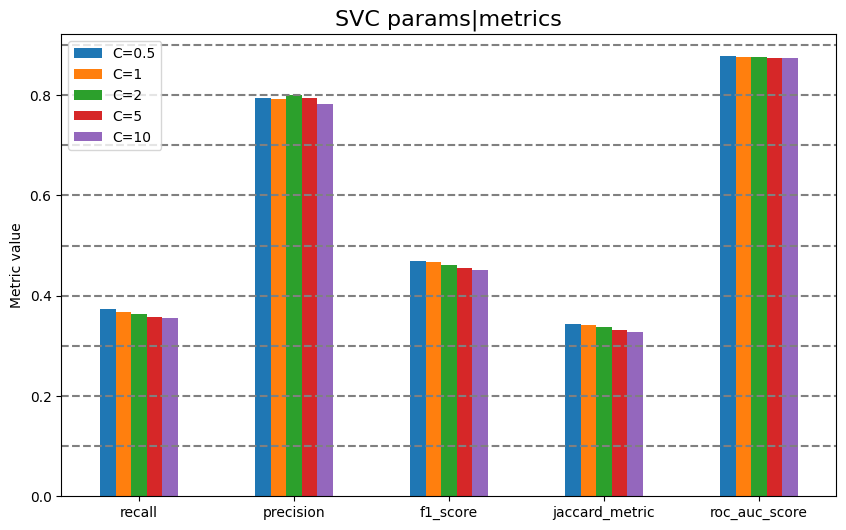

In [31]:
bar_svc = metrics_LinearSVC.T.plot.bar(figsize=(10,6))
bar_svc.set_title('SVC params|metrics', fontdict={'fontsize': 16, 'fontweight': 'medium'})
bar_svc.set_ylabel('Metric value')
process_plot(bar_svc)
bar_svc.figure.savefig('svc.png', facecolor='w',bbox_inches = 'tight')

In [32]:
metrics_MNB

,recall,precision,f1_score,jaccard_metric,roc_auc_score
alpha=0.05,0.186045,0.929663,0.291045,0.185338,0.832435
alpha=0.01,0.312764,0.827729,0.433320,0.299978,0.875737
alpha=0.005,0.313671,0.824691,0.434311,0.300659,0.875384
alpha=0.003,0.307838,0.856948,0.429869,0.295800,0.872313
alpha=0.001,0.293070,0.854577,0.416490,0.283250,0.862629


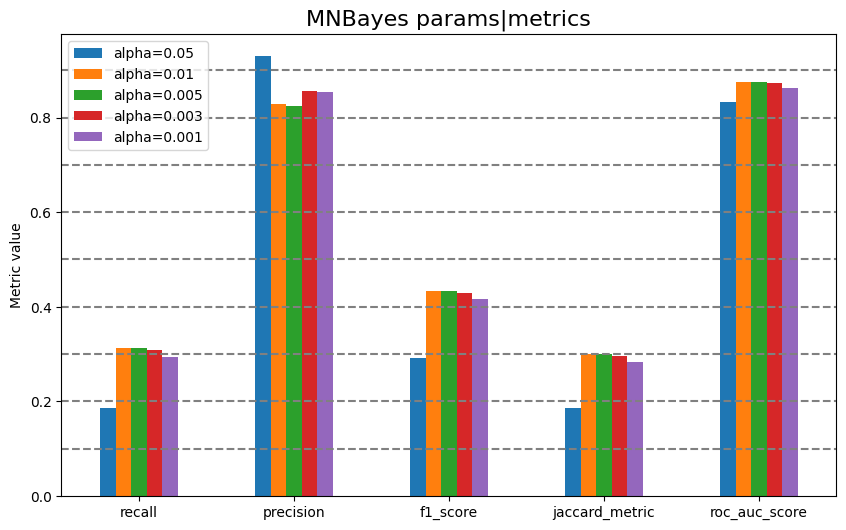

In [33]:
bar_mnb = metrics_MNB.T.plot.bar(figsize=(10,6))
bar_mnb.set_title('MNBayes params|metrics', fontdict={'fontsize': 16, 'fontweight': 'medium'})
bar_mnb.set_ylabel('Metric value')
process_plot(bar_mnb)
bar_mnb.figure.savefig('mnb.png', facecolor='w',bbox_inches = 'tight')

In [34]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


SVC + BERT embeddings

In [35]:
import torch
from datasets import Dataset
torch_y = torch.from_numpy(y_train.values)
labels = torch_y.to(torch.float)
labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [36]:
x_train_bert = df_train.plot_describe
x_val_bert  = df_val.plot_describe
x_test_bert = df_test.plot_describe

In [37]:
x_train_bert

1027    A sadistic serial killer, Patrick Channing (Je...
611     In Kotzebue, Alaska, bush pilot Mike Wein (Way...
3593    Rozat "Rusty" Sabich is a prosecutor and the r...
4036    In the South Seas, a volcano explodes, eventua...
4275    In 2011, a deadly pathogenic virus has killed ...
                              ...                        
1758    On his wedding anniversary, Han Chul-min (Jang...
2028    Hari (Sunil), a young businessman and Neha (Ra...
2833    The mysterious Green Knight appears before Kin...
4799    A man comes out of the office of "Garfield Inv...
872     Kevin Lenahan is an African-American con man w...
Name: plot_describe, Length: 2976, dtype: object

In [38]:
tf_val = pd.DataFrame()
tf_val['text'] = x_val_bert

tf_train = pd.DataFrame()
tf_train['text'] = x_train_bert

tf_test = pd.DataFrame()
tf_test['text'] = x_test_bert

In [39]:
from transformers import AutoModel,AutoTokenizer
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [40]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

In [41]:
tf_train_bert = pd.DataFrame()
tf_train_bert['text'] = x_val_bert
tf_train_bert

,text
338,A pushy newspaper reporter Eddie Crane (Ned Sp...
2352,"Based on the 1963 book by Robert MacLeod,[2] t..."
3426,"Jeet Johar, is a ruthless Indo-Canadian gangst..."
2194,The film begins with scenes of life in Wyoming...
4931,A millionaire is murdered at a séance at a for...
...,...
933,Verden Fell (Vincent Price) is both mournful a...
1652,"While on the phone with his girlfriend Jill, w..."
165,Five young people decide that life is not wort...
748,"Charlie Bellow, a polite, kind-hearted young m..."


In [42]:
df_val_bert = pd.DataFrame()
df_val_bert['text'] = x_val_bert
df_val_bert

,text
338,A pushy newspaper reporter Eddie Crane (Ned Sp...
2352,"Based on the 1963 book by Robert MacLeod,[2] t..."
3426,"Jeet Johar, is a ruthless Indo-Canadian gangst..."
2194,The film begins with scenes of life in Wyoming...
4931,A millionaire is murdered at a séance at a for...
...,...
933,Verden Fell (Vincent Price) is both mournful a...
1652,"While on the phone with his girlfriend Jill, w..."
165,Five young people decide that life is not wort...
748,"Charlie Bellow, a polite, kind-hearted young m..."


In [43]:
BATCH_SIZE = 4

class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.df = df.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        text = self.df.loc[idx,"text"]
        tokens = tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=MAX_LEN,return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens

In [44]:
def create_dataloader(df):
    ds = EmbedDataset(df)
    return torch.utils.data.DataLoader(ds,\
                        batch_size=BATCH_SIZE,\
                        shuffle=False)

In [45]:
embed_dataloader_train = create_dataloader(tf_train)
embed_dataloader_val = create_dataloader(tf_val)
embed_dataloader_test = create_dataloader(tf_test)

In [46]:
tokenizer = None
MAX_LEN = 640

def get_embeddings(embed_dataloader, MODEL_NM='', MAX=640, BATCH_SIZE=4):
    global tokenizer, MAX_LEN
    DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AutoModel.from_pretrained( MODEL_NM )
    tokenizer = AutoTokenizer.from_pretrained( MODEL_NM )
    MAX_LEN = MAX

    model = model.to(DEVICE)
    model.eval()
    all_train_text_feats = []
    for batch in tqdm(embed_dataloader, total=len(embed_dataloader)):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        with torch.no_grad():
            model_output = model(input_ids=input_ids,attention_mask=attention_mask)
        sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
        # Normalize the embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
        all_train_text_feats.extend(sentence_embeddings)
    all_train_text_feats = np.array(all_train_text_feats)
    return all_train_text_feats

In [ ]:
#MODEL_NM = '/kaggle/input/huggingface-roberta-variants/archive/roberta-base/roberta-base'
MODEL_NM = 'cardiffnlp/twitter-roberta-base-emotion'
train_text_feats = get_embeddings(embed_dataloader_train, MODEL_NM, MAX=512)
val_text_feats = get_embeddings(embed_dataloader_val, MODEL_NM, MAX=512)
test_text_feats = get_embeddings(embed_dataloader_test, MODEL_NM, MAX=512)

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
metrics_LinearSVC = pd.DataFrame()

In [ ]:
for param in tqdm([0.1, 0.2, 0.5, 1, 2, 5, 10]):
    calibrated_clf = CalibratedClassifierCV(LinearSVC(C=param))
    clf = OneVsRestClassifier(calibrated_clf).fit(train_text_feats, y_train)
    svc_prediction = np.array(clf.predict_proba(val_text_feats))
    save_results_iter(metrics_LinearSVC, svc_prediction, y_val, 'C', param)

RoBERTa+SVC trained

In [ ]:
metrics_LinearSVC

In [ ]:
bar_svc = metrics_LinearSVC.T.plot.bar(figsize=(10,6))
bar_svc.set_title('RoBERTa + SVC params|metrics', fontdict={'fontsize': 16, 'fontweight': 'medium'})
bar_svc.set_ylabel('Metric value')
process_plot(bar_svc)
bar_svc.figure.savefig('deberta+svc.png', facecolor='w',bbox_inches = 'tight')

In [ ]:
class_names = y_train.keys()
class_names

In [ ]:
y_train

In [ ]:
test_df = pd.DataFrame(x_test_bert)
test_df['text'] = x_test_bert.values
test_df['labels'] = y_test.agg(list, axis=1)
test_df.drop(['plot_describe'], axis=1, inplace=True)
test_df

In [ ]:
val_df = pd.DataFrame(x_val_bert)
val_df['text'] = x_val_bert.values
val_df['labels'] = y_val.agg(list, axis=1)
val_df.drop(['plot_describe'], axis=1, inplace=True)
val_df

In [ ]:
!pip install -q -U simpletransformers
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from simpletransformers.classification import MultiLabelClassificationModel

model = MultiLabelClassificationModel('roberta', '/kaggle/input/d/vladislavkolesov/movie-genre-prediction-roberta-checkpoint/outputs/checkpoint-24660-epoch-3', num_labels=12, args={'train_batch_size':2, 'num_train_epochs': 3,'max_seq_length': 512, 'evaluate_during_training_steps':30000,'overwrite_output_dir': True, 'save_steps':24000,'use_multiprocessing':False, 'use_multiprocessing_for_evaluation':False})